#### Imports & Comments

Data Sourc UNHCR

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, kstest
import statsmodels.api as sm

In [12]:
seek_df = pd.read_csv('preprocessed_data.csv')

In [13]:
# colors
c1 = '#a14242' 
c2 = '#a3b8c8'
c3 = '#d28140'
c4 = '#119988'

# Country Asylum Application Decision Analysis Tool
Within this noteboom you can to select a country of interest for a detailed analysis. This interactive tool provides several key insights through different analytical views:
1. A time-series graph of the country's absolute numbers of rejected and accepted asylum applications, offering an immediate visualization of trends over recent years. This feature facilitates a quick understanding of how a country's asylum decisions have evolved.
2. A list of the primary countries of origin for asylum seekers applying to the selected country. This overview allows users to gauge the main sources of asylum applications and understand the direct impact of global migration patterns on the chosen country.
2. An evaluation of the predictability of a country's asylum decisions based on linear regression models, comparing its behavior to global trends. This aspect assesses how closely a country's asylum decision trends align with broader patterns.
3. A graph depicting the country's year-over-year rate of change in accepted and rejected asylum applications, accompanied by correlation and linear regression analyses (using both Spearman and Pearson coefficients). This parallels the methodologies applied in figures \ref{figs:canada} and \ref{figs:usa}, helping users determine whether there appears to be a policy or strategy regulating the balance between accepted and rejected applications.
4. A comparison of Rate of Change distributions, similar to the analysis in figure \ref{figs:usa_ecdf}. This comparison aims to highlight differences in distributions and assess whether one or both are centered around zero with a small standard deviation, potentially indicating a cap on asylum decisions.

## Pick a country

list of all countries:

In [14]:
print(list(seek_df['country_asylum'].unique()), end=', ')

['Zimbabwe', 'South Africa', 'Uzbekistan', 'United States of America', 'Ukraine', 'Turkey', 'Turkmenistan', 'Tajikistan', 'Thailand', 'Syrian Arab Rep.', 'Sweden', 'Slovenia', 'Slovakia', 'Serbia and Kosovo (S/RES/1244 (1999))', 'Russian Federation', 'Romania', 'Portugal', 'Poland', 'Nepal', 'Norway', 'Netherlands', 'Malaysia', 'Mozambique', 'The former Yugoslav Republic of Macedonia', 'Mexico', 'Rep. of Moldova', 'Luxembourg', 'Lithuania', 'Sri Lanka', 'Lebanon', 'Kuwait', 'Cambodia', 'Kyrgyzstan', 'Kenya', 'Kazakhstan', 'Japan', 'Jordan', 'Italy', 'Iceland', 'Iran (Islamic Rep. of)', 'Ireland', 'India', 'Indonesia', 'Hungary', 'Croatia', 'China, Hong Kong SAR', 'Greece', 'United Kingdom', 'France', 'Finland', 'Ethiopia', 'Estonia', 'Spain', 'Egypt', 'Denmark', 'Germany', 'Czech Rep.', 'Cyprus', 'Cuba', 'China', 'Switzerland', 'Canada', 'Belarus', 'Bosnia and Herzegovina', 'Bulgaria', 'Bangladesh', 'Belgium', 'Azerbaijan', 'Austria', 'Australia', 'Argentina', 'United Arab Emirates', '

Now write your country of choice as _mycountry_:

In [15]:
mycountry = 'United States of America'

Check if country is spelled right:

In [16]:
if mycountry in list(seek_df['country_asylum'].unique()):
    print('Yes, ', mycountry, ' is in the list.')
else:
    print('Check if you have a spelling mistake or if the country is not in the list.')

Yes,  United States of America  is in the list.


## 1. Trends Over Time: Analyzing Asylum Application Outcomes

This chapter provides a visual time-series analysis of asylum application decisions (accepted and rejected) for a selected country. It aims to offer an immediate understanding of how these decisions have evolved over recent years, highlighting trends and shifts in policy or practice.

In [32]:
def plt_absoulte_decisions(country):
    fig, ax = plt.subplots(figsize=(7, 4))

    country_df = seek_df.copy()[seek_df['country_asylum'] == country]
    country_df = country_df.groupby(['year']).sum()

    #plot accepted numbers
    sns.lineplot(data=country_df,
                x=country_df.index,
                y="accepted",
                label="Accepted Applications",
                c=c3)
    ax.fill_between(country_df.index, country_df['accepted'], color=c3, alpha=0.3)


    temp_r_df = country_df.copy()
    temp_r_df['rejected'] = temp_r_df['rejected'] + temp_r_df['accepted']

    sns.lineplot(data=temp_r_df,
                x=country_df.index,
                y="rejected",
                label="Rejected Applications",
                c=c4)
    ax.fill_between(country_df.index, temp_r_df['rejected'], country_df['accepted'], color=c4, alpha=0.3)

    # Place the legend in the center top
    plt.legend(loc='upper left', bbox_to_anchor=(0.3, .98), ncol=1)

    plt.axhline(max(country_df['accepted']), color=c3, linestyle='--')
    plt.axhline(min(country_df['accepted']), color=c3, linestyle='--')

    plt.title(country + ' Accepted/Rejected Asylum Applications')
    plt.xlabel('Year')
    plt.ylabel('Number of Applications  per year')
    plt.show()

c:\Users\hutte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\hutte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\hutte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\hutte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

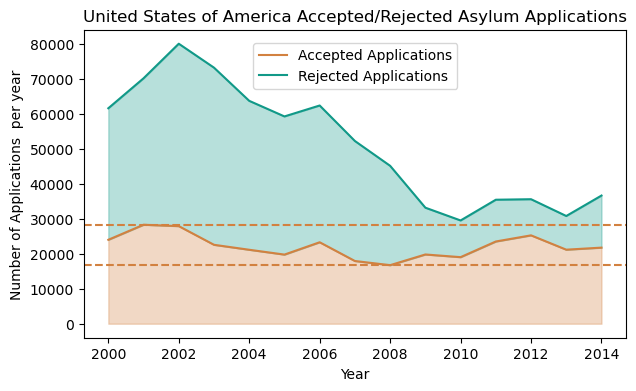

In [33]:
plt_absoulte_decisions(mycountry)

## 2. Global Migration Patterns: Identifying Primary Countries of Origin

In this chapter, the focus is on identifying and discussing the main countries of origin for asylum seekers applying to the selected country. This analysis helps to contextualize the asylum applications within the broader scope of global migration trends, offering insights into the geopolitical or socio-economic factors driving these movements.

In [19]:
mycountry_df = seek_df.copy()[seek_df['country_asylum'] == mycountry]

In [20]:
def plt_origin_countries(mycountry):
    # number of refugees per country of origin in total
    df_rc = mycountry_df[["country_origin", "applications"]]
    df_rc = df_rc.groupby('country_origin').sum()
    df_rc = df_rc.sort_values(by='applications', ascending=False)

    # plot the top 10 countries with most refugees
    df_rc.head(15).sort_values(by='applications', ascending=True).plot(kind='barh', figsize=(7, 3), color=c1)
    plt.title('Countries where most refugees are coming from\n for application country ' + mycountry)
    plt.xlabel('Number of Applications')
    plt.legend().remove()
    plt.ylabel('')
    plt.show()
    return

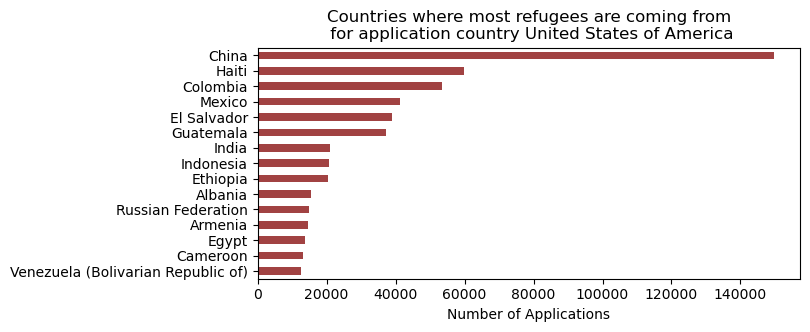

In [21]:
plt_origin_countries(mycountry)

## 3. Predictability of Asylum Decisions: A Linear Regression Approach

This chapter evaluates the predictability of asylum decisions through linear regression models, comparing the selected country's trends with global patterns. It assesses the consistency of the country's asylum decisions and how they align or deviate from broader tendencies, providing a quantitative measure of predictability.

In [22]:
def plt_global_trend_position(mycountry):
    fig, ax = plt.subplots(figsize=(7, 4))

    country_df = seek_df[['country_asylum','rejected','accepted']].copy().groupby('country_asylum').sum()
    country_df['country_asylum'] = country_df.index
    # calculate linear regression
    x = country_df['accepted']
    y = country_df['rejected']

    x = sm.add_constant(x)
    model_sm = sm.OLS(y,x).fit()
    R2 = model_sm.rsquared

    # plot the data
    sns.scatterplot(data=country_df, x='accepted', y='rejected', c=c3, label='Countries')

    # plot mycountry
    rejected_values = country_df.loc[country_df['country_asylum'] == mycountry, 'rejected'].values
    accepted_values = country_df.loc[country_df['country_asylum'] == mycountry, 'accepted'].values
    plt.scatter(accepted_values, rejected_values, color='red', s= 50, marker='o', label=mycountry)


    # get linear regression mode
    a = model_sm.params['const']
    b = model_sm.params['accepted']

    x_pred = sorted(country_df['accepted'].tolist())

    lin_reg = lambda x: a + b * x
    y_pred = [lin_reg(i) for i in x_pred]

    # plot the linear regression
    plt.plot(x_pred, y_pred, color=c1, label="lin. reg.")

    # plot parameters and information
    plt.text(.5, .03, '$Rejected = %.2f + %.2f \cdot Accepted$'%(a,b), transform=ax.transAxes)
    #plt.text(.05, .89, '$R^2 = %.2f$'%(R2), transform=ax.transAxes)

    plt.xlabel('Number of Accepted Applications')
    plt.ylabel('Number of Rejected Applications')
    plt.title('Linear Regression Countries\n Accumulated Accepted vs Rejected Asylum Applications ', fontsize=15)
    plt.legend( loc='upper left')

    plt.xscale('log')
    plt.yscale('log')
    plt.show()

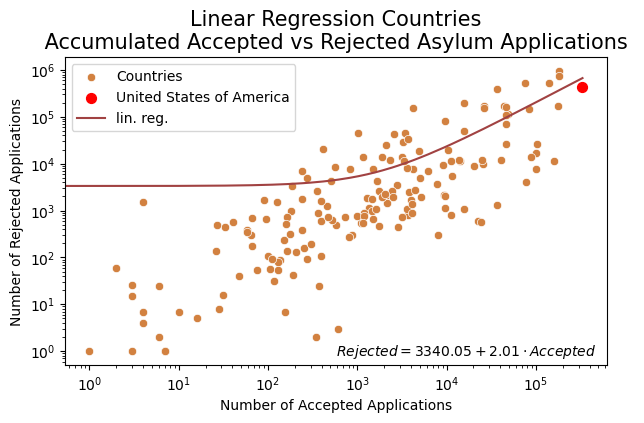

In [23]:
plt_global_trend_position(mycountry)

## 4. Year-over-Year Changes: Dynamics of Asylum Application Decisions
Through the use of graphs and regression analyses, this chapter examines the year-over-year rate of change in asylum decisions, incorporating correlation analyses to understand the underlying factors influencing these shifts. It aims to uncover any systemic strategies or policies that may be affecting the balance between acceptance and rejection rates.

In [24]:
def plt_rateofchange_correlation(country_name=mycountry, df=seek_df):
    # create df for country
    country_df = df[df['country_asylum'] == country_name].copy().drop(['country_asylum', 'country_origin','rsd_procedure'],axis=1)
    country_df = country_df.groupby(['year']).sum()

    # calculate rate of cange for accepted and rejected calculations per year
    country_df['accepted_rate'] = country_df['accepted'].pct_change()
    country_df['rejected_rate'] = country_df['rejected'].pct_change()

    # drop the earlist year
    country_df = country_df.drop(country_df.index[0])


    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 4), sharey=True)

    # timeseries
    country_df[['accepted_rate','rejected_rate']].plot(kind='bar', ax=ax1, color=[c3,c4], rot=45)
    ax1.xaxis.grid(True)  # set grid
    ax1.axhline(y=0, color=c2, linestyle='--')

    #plot line at 0
    ax1.set_title('Time-Series')
    ax1.set_xlabel('')
    ax1.legend( loc='lower left')

    # scatterplot
    country_df.plot.scatter(x="accepted_rate", y="rejected_rate", ax=ax2, color=c1, s=50, label='years', )
    ax2.set_xlabel('Rate of Change accepted AAO')
    ax2.set_title('Correlation Plot')

    # lin regression
    # calculate linear regression
    x = country_df['accepted_rate']
    y = country_df['rejected_rate']
    x = sm.add_constant(x)
    model_sm = sm.OLS(y,x).fit()
    R2 = model_sm.rsquared
    a = model_sm.params['const']
    b = model_sm.params['accepted_rate']
    x_pred = sorted([-1.5,0,1.5])
    lin_reg = lambda x: a + b * x
    y_pred = [lin_reg(i) for i in x_pred]

    ax2.plot(x_pred, y_pred, color='r', linestyle='--', label="linear regression")
    ax2.axhline(y=0, color=c2, linestyle='--')
    ax2.legend( loc='lower left')


    # adding regression coefficient
    plt.text(.02, .94, 'RoC Rejected $= %.2f + %.2f \cdot$ RoC Accepted'%(a,b), transform=ax2.transAxes)
    #plt.text(1.25, 1.13, '$R^2 = %.2f$'%(R2), transform=ax.transAxes)

    # adding p-value and correlation coefficient
    pear_correlation, pear_p_value = pearsonr(country_df['accepted_rate'], country_df['rejected_rate'])
    plt.text(.02, .82, 'Pearson $= %.2f  (%.4f)$'%(pear_correlation, pear_p_value), transform=ax2.transAxes)
    
    spea_correlation, spea_p_value = spearmanr(country_df['accepted_rate'], country_df['rejected_rate'])
    plt.text(.02, .88, 'Spearman $= %.2f  (%.4f)$'%(spea_correlation, spea_p_value), transform=ax2.transAxes)

    # other plot settings
    ax2.set_xlim(-1.5, 1.5)
    ax2.set_ylim(-1.5, 1.5)
    ax1.set_ylabel('Rate of Change \n(Rejected for Correlation Plot)')

    fig.tight_layout()

    plt.suptitle(f'Asylum Applications in {country_name}', y=1.05)

    plt.show()
    return

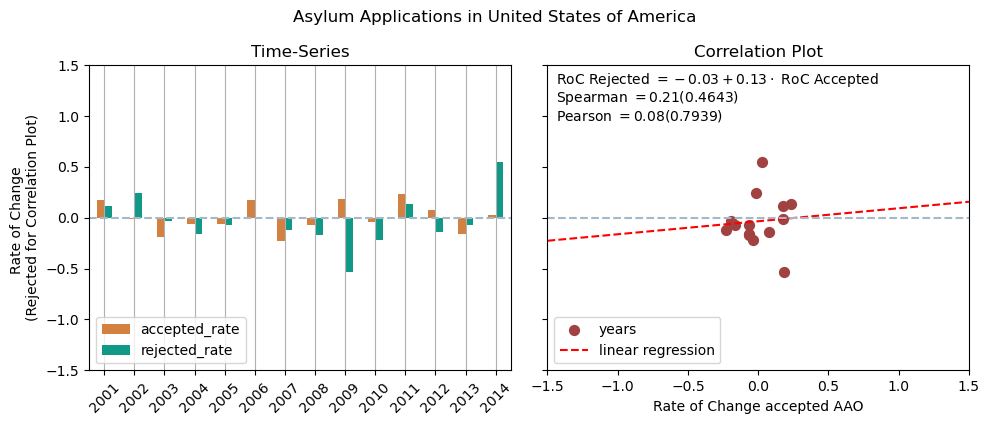

In [25]:
plt_rateofchange_correlation()

## 5. Comparative Analysis of Decision Trends: Assessing Rate of Change Distributions
The final chapter offers a comparative look at the distributions of rate of change in asylum decisions, similar to previous analytical figures. This comparison seeks to determine if there is evidence of a regulatory cap or a standard deviation centered around zero, which might indicate a controlled approach to asylum decisions.

In [26]:
def plt_rof_distributions(country_name=mycountry, df=seek_df, plt_mean=True):
    # create df for country
    country_df = df[df['country_asylum'] == country_name].copy().drop(['country_asylum', 'country_origin','rsd_procedure'],axis=1)
    country_df = country_df.groupby(['year']).sum()

    # calculate rate of cange for accepted and rejected calculations per year
    country_df['accepted_rate'] = country_df['accepted'].pct_change()
    country_df['rejected_rate'] = country_df['rejected'].pct_change()

    # drop the earlist year
    country_df = country_df.drop(country_df.index[0])

    country_df = country_df[['accepted_rate','rejected_rate']].replace([np.inf, -np.inf], np.nan).dropna()  # Replace inf values with NaN

    fig, ax = plt.subplots(figsize=(9, 5))

    ### coutntry elements distirbution
    elements_acc = country_df['accepted_rate']
    elements_rec = country_df['rejected_rate']
    # Remove inf and nan values
    elements_acc = elements_acc.replace([np.inf, -np.inf, np.nan], np.nan).dropna()
    elements_acc = elements_acc.tolist()
    elements_rec = elements_rec.replace([np.inf, -np.inf, np.nan], np.nan).dropna()
    elements_rec = elements_rec.tolist()


    # plot histogram
    bins = np.histogram_bin_edges(elements_acc, bins='auto')
    sns.histplot(elements_acc, bins=bins, color=c3, alpha=0.7, label='RoC Accepted', kde=True, ax=ax)
    sns.histplot(elements_rec, bins=bins, color=c4, alpha=0.7, label='RoC Rejected', kde=True, ax=ax)

    # plot results ks test
    ks_statistic_acc, p_value_acc = kstest(elements_acc, elements_rec)
    inserting = "KS-Test $= " + str(ks_statistic_acc)[:5] + " (" + str(p_value_acc)[:5] + ")$"
    plt.text(.02, 0.7, inserting, transform=ax.transAxes)

    # visualize mean, median, std
    std_dev_acc = np.std(elements_acc)
    mean_acc = np.mean(elements_acc)
    median_acc = np.median(elements_acc)
    std_dev_rec  = np.std(elements_rec )
    mean_rec = np.mean(elements_rec )
    median_rec = np.median(elements_rec )

    # plot the mean/median
    if plt_mean:
        ax.axvline(mean_acc, color=c3, linestyle='--', label='Mean RoC Accepted')
        ax.axvline(mean_rec, color=c4, linestyle='--', label='Mean RoC Rejected')
    else:
        ax.axvline(median_acc, color=c3, linestyle='--', label='Median RoC Accepted')
        ax.axvline(median_rec, color=c4, linestyle='--', label='Median RoC Rejected')
        

    inserting = "STD RoC Accepted $= " + str(std_dev_acc)[:5] + "$"
    plt.text(0.02, 0.65, inserting, transform=ax.transAxes)
    inserting = "STD RoC Rejected $= " + str(std_dev_rec)[:5] + "$"
    plt.text(.02, 0.6, inserting, transform=ax.transAxes)


    plt.title('Distribution Comparison ' + mycountry)
    ax.legend(loc='upper left')

    plt.show()
    return

c:\Users\hutte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\hutte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


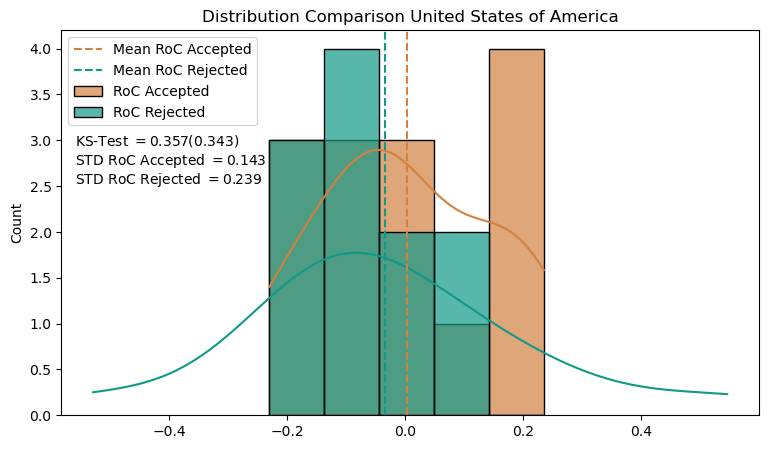

In [27]:
plt_rof_distributions(plt_mean=True)